# Stock Market Sentiment Analysis

The following Python project aims to retreive a number of articles using the Google News 

In [96]:
# Load necessary packages

import requests
import json
import pandas as pd
import os
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy as sp
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from pandas_market_calendars import get_calendar
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_market_calendars import get_calendar

We first set important global variables, such as the date of today.

In [131]:
today = datetime.datetime.now().date()
nlp = sp.load("en_core_web_sm")
current_directory = os.getcwd()
os.chdir(current_directory)

# Pipeline

In [111]:
def fetch_articles(category, start_date, end_date):
    """
    Fetches articles from the specified category within the given date range using the GNews API.

    Parameters:
    - category (str): The category of articles to fetch.
    - start_date (str): The start date of the date range in 'YYYY-MM-DD' format.
    - end_date (str): The end date of the date range in 'YYYY-MM-DD' format.

    Returns:
    - list: A list of dictionaries representing the fetched articles.
    """
    
    api_key = '88edd99823231ee937f06064cd930842'
    url = f"https://gnews.io/api/v4/top-headlines?category={category}&from={start_date}&to={end_date}&lang=en&country=us&max=100&apikey={api_key}"
    response = requests.get(url)
    articles = json.loads(response.text)['articles']
    return articles

In [112]:
def calculate_sentiment_scores(text):
    """
    Calculates sentiment scores for the given text using the VADER sentiment analysis tool.

    Parameters:
    - text (str): The text for which sentiment scores are to be calculated.

    Returns:
    - dict: A dictionary containing sentiment scores (neg, neu, pos, compound).
    """
    
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)

In [113]:
def export_sentiment_data(sentiment_scores):
    """
    Exports sentiment scores data to a CSV file.

    Parameters:
    - sentiment_scores (dict): A dictionary containing sentiment scores for articles.

    Returns:
    - None
    """

    # Convert data to list of dictionaries
    data_list = []
    for title, scores in sentiment_scores.items():
        row = {'date': today, 'title': title, **scores}
        data_list.append(row)

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data_list)
    
    # Define CSV file name
    csv_file_name = f"sentiment_scores_{today}.csv"

    # Export DataFrame to CSV file
    df.to_csv(csv_file_name, index=False)

    print(f"Data has been exported to '{csv_file_name}' successfully.")

In [101]:
def export_daily_data(sentiment_scores, sp500):
    """
    Finds the file called 'daily_data.csv', loads it, and adds a new row to it.
    The new row includes date, sentiment scores, and S&P 500 data based on the parameters.

    Parameters:
    - sentiment_scores (dict): A dictionary containing sentiment scores.
    - sp500 (float): The S&P 500 data for the current date.

    Returns:
    - pd.DataFrame: The updated DataFrame containing daily data.
    """
    # Check if 'daily_data.csv' file exists
    if os.path.exists('daily_data.csv'):
        # Load existing data into a DataFrame
        daily_data = pd.read_csv('daily_data.csv')
    else:
        # Create a new DataFrame if 'daily_data.csv' doesn't exist
        daily_data = pd.DataFrame(columns=['Date', 'Sentiment_Score', 'S&P500'])

    # Get today's date
    today_date = pd.to_datetime('today').strftime('%Y-%m-%d')

    # Create a new row with today's date, sentiment scores, and S&P 500 data
    new_row = {'Date': today_date, 'Sentiment_Score': sentiment_scores, 'S&P500': sp500}

    # Append the new row to the DataFrame
    daily_data = daily_data.append(new_row, ignore_index=True)

    # Save the updated DataFrame to 'daily_data.csv'
    daily_data.to_csv('daily_data.csv', index=False)

    return daily_data

In [125]:
def get_sp500_price(start):
    """
    Get the adjusted close price of the S&P 500 index from Yahoo Finance for a specific date.
    If the given date is not a trading day for the S&P 500, return the price for the last trading day.

    Parameters:
    - start (datetime.date): Date for which to retrieve the price.

    Returns:
    - float: Adjusted close price of the S&P 500 on the specified date or the last trading day.
    """
    # Transform the date parameter into a string
    start_date_str = start.strftime('%Y-%m-%d')

    # Get the next day as a string
    end_date = start + datetime.timedelta(days=1)
    end_date_str = end_date.strftime('%Y-%m-%d')


    # Define the ticker symbol for the S&P 500 index
    sp500_ticker = '^GSPC'  # S&P 500 index ticker symbol

    # Check if the given date is a trading day for the S&P 500
    sp500_calendar = get_calendar('NYSE')
    if not sp500_calendar.valid_days(start_date=start_date_str, end_date=end_date_str).empty:
        # If the given date is a trading day, fetch historical data for the S&P 500 index from Yahoo Finance
        sp500_data = yf.download(sp500_ticker, start=start_date_str, end=end_date_str)
        # Extract the adjusted close price for the specified date
        sp500_price = sp500_data['Adj Close']
    else:
        # If the given date is not a trading day, find the last trading day and get the price for that day instead
        last_trading_day = sp500_calendar.previous_trading_day(start_date_str)
        sp500_data_last = yf.download(sp500_ticker, start=last_trading_day, end=last_trading_day)
        sp500_price = sp500_data_last['Adj Close']

    return sp500_price

print(get_sp500_price(datetime.date(2024,4,7)))

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^GSPC: No data found for this date range, symbol may be delisted


IndexError: index 0 is out of bounds for axis 0 with size 0

# Retreive articles

Using the API of Google News, we retrieve the maximum possible number of business news for today.

In [69]:
# Load all possible articles for today
category = "business"
articles = fetch_articles(category, today, today)

# Extract both the title and the description component of all articles
descriptions = [article['description'] for article in articles]

# Calculate sentiment score
Using Vader, we calculate the sentiment score for each article, as well as the given day in total.
We also retrive the daily market price for the S&P 500 and save the data together in a CSV file for each day.

In [143]:
sentiment_scores = {}
total_sentiment = {
    'neg': 0,
    'pos': 0,
    'neu': 0,
    'compound': 0
}

# Text preprocessing and sentiment score calculation
for article in articles:
    current_score = calculate_sentiment_scores(article['description'])
    sentiment_scores[article['title']] = current_score
    total_sentiment['neg'] += current_score['neg']
    total_sentiment['pos'] += current_score['pos']
    total_sentiment['neu'] += current_score['neu']
    total_sentiment['compound'] += current_score['compound']

for key, value in sentiment_scores.items():
    print(key, ':', value)

# Calculating the total sentiment scores for today
num_articles = len(sentiment_scores)
total_sentiment['neg'] /= num_articles
total_sentiment['neu'] /= num_articles
total_sentiment['pos'] /= num_articles
total_sentiment['compound'] /= num_articles

print(total_sentiment)

# Getting today's SP500 price
sp500 = get_sp500_price(today)

# Saving CSV files
export_sentiment_data(sentiment_scores)
export_daily_data(total_sentiment, sp500)


From $1,000 in savings to bringing in $25M/year : {'neg': 0.205, 'neu': 0.737, 'pos': 0.059, 'compound': -0.655}
It may not be long before Arbitrum outshines Ethereum, but only if… : {'neg': 0.057, 'neu': 0.648, 'pos': 0.295, 'compound': 0.7089}
Insurance Companies Reap Hidden Fees as Patients Get Unexpected Bills : {'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'compound': 0.3818}
What’s wrong with Tesla : {'neg': 0.257, 'neu': 0.743, 'pos': 0.0, 'compound': -0.91}
California could become first state to give workers a ‘right to disconnect’ : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Cleveland Hopkins airport plane crash and fire : {'neg': 0.175, 'neu': 0.825, 'pos': 0.0, 'compound': -0.6249}
Plane crashes at Cleveland Hopkins International Airport : {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263}
Airfield reopens after planes diverted from Cleveland Hopkins International Airport for plane crash : {'neg': 0.095, 'neu': 0.905, 'pos': 0.0, 'compound': -0.2263}
Is the 

/var/folders/_b/y53qt2896kq2xm42py9r4fmh0000gn/T/ipykernel_28405/4076304037.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  daily_data = daily_data.append(new_row, ignore_index=True)


,Date,Sentiment_Score,S&P500
0,2024-04-07,"{'neg': 0.1, 'neu': 0.6, 'pos': 0.3, 'compound...",4000.0
1,2024-04-07,"{'neg': 0.1, 'neu': 0.6, 'pos': 0.3, 'compound...",4000.0
2,2024-04-07,"{'neg': 0.12830000000000003, 'pos': 0.05669999...","Series([], Name: Adj Close, dtype: float64)"
3,2024-04-08,"{'neg': 0.12830000000000003, 'pos': 0.05669999...",100
4,2024-04-08,"{'neg': 0.12830000000000003, 'pos': 0.05669999...",5205.31005859375
5,2024-04-08,"{'neg': 0.12830000000000003, 'pos': 0.05669999...",5205.72998


# Diagrams & Results
Creating a Scatterplot comparing the sentiment of the individual articles.

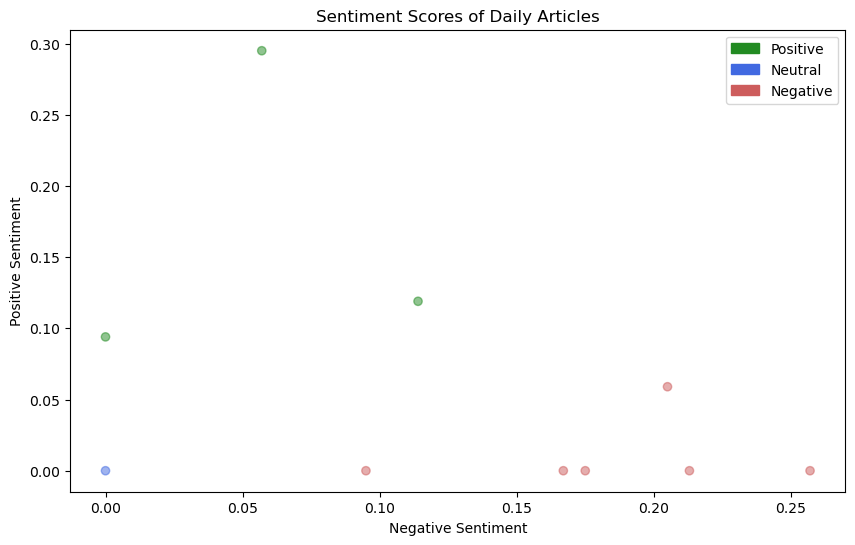

In [133]:
# Separate data for plotting
x = [article['neg'] for article in sentiment_scores.values()]
y = [article['pos'] for article in sentiment_scores.values()]
colors = ['forestgreen' if article['compound'] > 0 else 'royalblue' if article['compound'] == 0 else 'indianred' for article in sentiment_scores.values()]

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, alpha=0.5)
plt.title('Sentiment Scores of Daily Articles')
plt.xlabel('Negative Sentiment')
plt.ylabel('Positive Sentiment')

# Customize legend
green_patch = mpatches.Patch(color='forestgreen', label='Positive')
blue_patch = mpatches.Patch(color='royalblue', label='Neutral')
red_patch = mpatches.Patch(color='indianred', label='Negative')

# Additional plot settings
plt.legend(handles=[green_patch, blue_patch, red_patch], loc='upper right', fontsize='medium')
plt.grid(False)
plt.show()


Creating a Heatmap comparing each sentiment score (incl. compounded) of the individual articles by title.

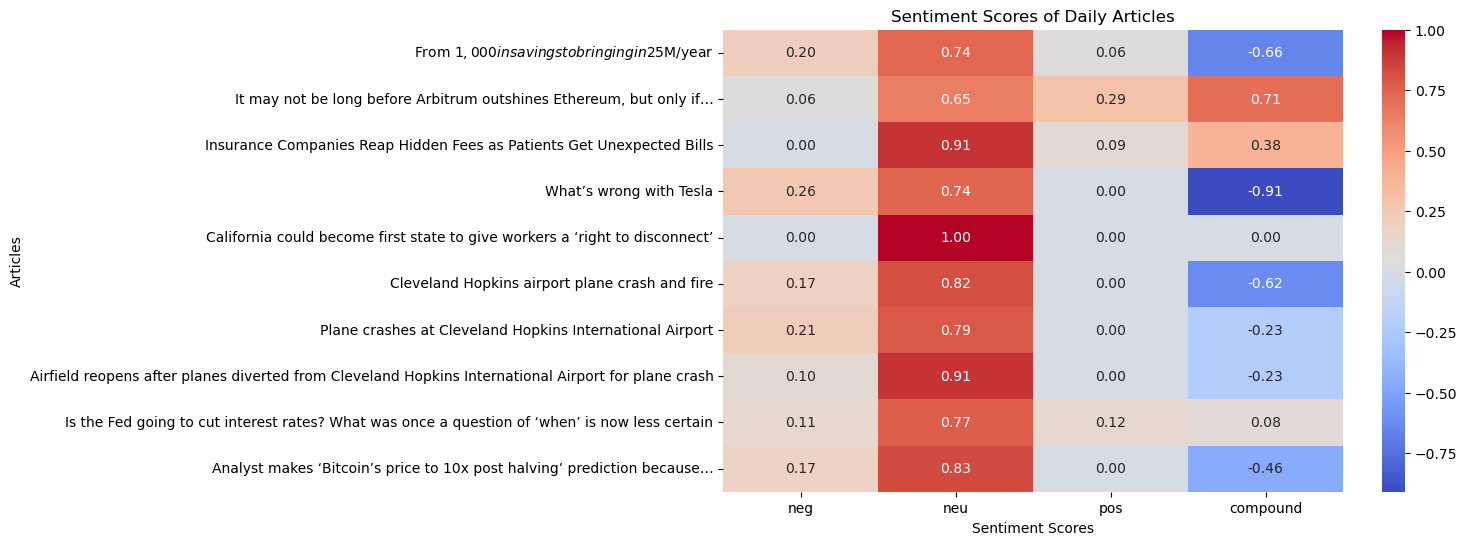

In [134]:
# Create DataFrame based on the data
df = pd.DataFrame(sentiment_scores).T

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['neg', 'neu', 'pos', 'compound']], cmap='coolwarm', annot=True, fmt=".2f")

# Additional plot settings
plt.title('Sentiment Scores of Daily Articles')
plt.xlabel('Sentiment Scores')
plt.ylabel('Articles')
plt.show()


Creating a bar plot displaying the relative sentiment of the market, displayed as the ratio of positive and negative sentiments.
Since sentiment scores can range from -1 to 1, following thresholds values are defined:

- negative: between -1 and -0.1
- neutral: between -0.1 and 0.1
- positive: between 0.1 and 1

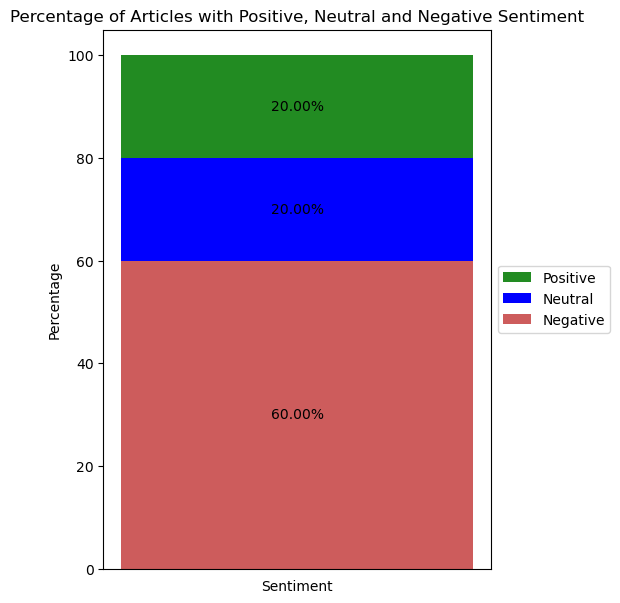

In [159]:
# Count positive and negative articles
positive_count = sum(1 for score in sentiment_scores.values() if score['compound'] > 0.1)
neutral_count = sum(1 for score in sentiment_scores.values() if score['compound'] < 0.1 and score['compound'] > -0.1)
negative_count = sum(1 for score in sentiment_scores.values() if score['compound'] < -0.1)

# Calculate percentages
total_articles = len(sentiment_scores)
positive_percent = (positive_count / total_articles) * 100
neutral_percent = (neutral_count / total_articles) * 100
negative_percent = (negative_count / total_articles) * 100

# Bar Plot
plt.figure(figsize=(5, 7))
plt.bar([0.5], [positive_percent], color='forestgreen', bottom=negative_percent + neutral_percent, label='Positive')
plt.bar([0.5], [neutral_percent], color='blue', bottom=negative_percent, label='Neutral')
plt.bar([0.5], [negative_percent], color='indianred', label='Negative')

# Add text labels
plt.text(0.5, negative_percent / 2, f'{negative_percent:.2f}%', ha='center', va='center')
plt.text(0.5, negative_percent + neutral_percent / 2, f'{neutral_percent:.2f}%', ha='center', va='center')
plt.text(0.5, negative_percent + neutral_percent + positive_percent / 2, f'{positive_percent:.2f}%', ha='center', va='center')

# Additional plot settings
plt.title('Percentage of Articles with Positive, Neutral and Negative Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Position legend to the right outside of the diagram
plt.show()


# Historic Data & Trend Analysis

We display the trend using a line chart.

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have lists of time points and corresponding sentiment scores
time_points = [1,2,3]  # List of time points
sentiment_scores = [4,5,6]  # List of sentiment scores

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(time_points, sentiment_scores, marker='o', linestyle='-')
plt.title('Sentiment Analysis of the Stock Market')
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()
